<a href="https://colab.research.google.com/github/furygrim/Badminton-Court-Detection-App/blob/main/courtdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running the code,Paste your own  input video path and output video path in the variables.

In [ ]:
!pip install streamlit -q
!npm install localtunnel -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 3s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼

Testing on a single frame of input video.

In [ ]:
import cv2
import numpy as np
from google.colab import files

def adjust_boundary(points, scale_factor=1.0):
    center = np.mean(points, axis=0)
    adjusted_points = (points - center) * scale_factor + center
    return adjusted_points.astype(int)

def detect_court(frame, scale_factor=1.0):
    # Convert to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define HSV range for court color (adjust based on video)
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([85, 255, 255])

    # Threshold to isolate court color
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Select the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate contour to a polygon
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    if len(approx) != 4:
        return None

    return adjust_boundary(approx.reshape(4, 2), scale_factor)

def process_video(input_path, output_path, scale_factor=1.0):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Setup video writer to save the processed output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    prev_mask = None
    prev_court_points = None
    alpha = 0.2  # Smoothing factor

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Fix upside-down frames and mirroring
        frame = cv2.flip(frame, -1)

        court_points = detect_court(frame, scale_factor)
        if court_points is None and prev_court_points is not None:
            court_points = prev_court_points  # Use last valid court detection

        if court_points is not None:
            prev_court_points = court_points  # Update last valid court detection

            # Create mask for the court
            mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
            cv2.fillConvexPoly(mask, court_points.astype(int), 255)

            # Smooth transition of mask
            if prev_mask is None:
                prev_mask = mask.astype(np.float32)
            else:
                prev_mask = alpha * mask.astype(np.float32) + (1 - alpha) * prev_mask

            smoothed_mask = prev_mask.astype(np.uint8)
            masked_frame = cv2.bitwise_and(frame, frame, mask=smoothed_mask)
        else:
            masked_frame = frame  # Use original frame if no court detected

        out.write(masked_frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    input_video = "/content/PXL_20250125_091952723.TS.mp4"  # Update as needed
    output_video = "/content/output_video1f.mp4"
    scale_factor = 1.9  # Adjust the court boundary dynamically
    process_video(input_video, output_video, scale_factor)

    # Trigger file download in Colab
    files.download(output_video)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%writefile app2.py
import cv2
import numpy as np
import streamlit as st
import tempfile
import os

def adjust_boundary(points, scale_factor=1.0):
    center = np.mean(points, axis=0)
    adjusted_points = (points - center) * scale_factor + center
    return adjusted_points.astype(int)

def detect_court(frame, scale_factor=1.0):
    # Convert to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Define HSV range for court color (adjust based on video)
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([85, 255, 255])
    # Threshold to isolate court color
    mask = cv2.inRange(hsv, lower_green, upper_green)
    # Morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    # Select the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    # Approximate contour to a polygon
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    if len(approx) != 4:
        return None
    return adjust_boundary(approx.reshape(4, 2), scale_factor)

def process_video(input_path, output_path, scale_factor=1.0):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        st.error("Error opening video file")
        return
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # Video writer setup (same dimensions as input)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    prev_mask = None
    prev_court_points = None
    alpha = 0.2  # Smoothing factor

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Fix upside-down frames and mirroring
        frame = cv2.flip(frame, -1)

        court_points = detect_court(frame, scale_factor)
        if court_points is None and prev_court_points is not None:
            court_points = prev_court_points  # Use last valid detection

        if court_points is not None:
            prev_court_points = court_points  # Update last valid detection

            # Create mask for the court
            mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
            cv2.fillConvexPoly(mask, court_points.astype(int), 255)

            # Smooth transition of mask
            if prev_mask is None:
                prev_mask = mask.astype(np.float32)
            else:
                prev_mask = alpha * mask.astype(np.float32) + (1 - alpha) * prev_mask

            smoothed_mask = prev_mask.astype(np.uint8)
            masked_frame = cv2.bitwise_and(frame, frame, mask=smoothed_mask)
            out.write(masked_frame)
        else:
            out.write(frame)  # Write original frame if no court detected

    cap.release()
    out.release()
    cv2.destroyAllWindows()

st.title("Court Boundary Detection & Dynamic Scale Factor Adjustment")

st.markdown("""
This application allows you to upload a video and adjust the court boundary scale factor dynamically.
The processed output video (with adjusted court boundaries) is shown side by side with the original.
""")

# Upload video file
uploaded_file = st.file_uploader("Upload a video file", type=["mp4", "mov", "avi", "TS"])

# Slider to select scale factor
scale_factor = st.slider("Adjust Scale Factor", min_value=0.5, max_value=3.0, value=1.9, step=0.1)

if uploaded_file is not None:
    # Save the uploaded video to a temporary file
    input_temp = tempfile.NamedTemporaryFile(delete=False, suffix=".mp4")
    input_temp.write(uploaded_file.read())
    input_temp_path = input_temp.name
    input_temp.close()

    # Create a temporary file for the output video
    output_temp = tempfile.NamedTemporaryFile(delete=False, suffix=".mp4")
    output_temp_path = output_temp.name
    output_temp.close()

    if st.button("Process Video"):
        st.info("Processing video, please wait...")
        process_video(input_temp_path, output_temp_path, scale_factor)
        st.success("Video processing complete!")

        # Read the input and output video files as bytes for display and download
        with open(input_temp_path, 'rb') as f:
            input_video_bytes = f.read()
        with open(output_temp_path, 'rb') as f:
            output_video_bytes = f.read()

        # Layout the two videos side by side
        col1, col2 = st.columns(2)
        with col1:
            st.subheader("Input Video")
            st.video(input_video_bytes)
        with col2:
            st.subheader("Output Video")
            st.video(output_video_bytes)

        # Provide download button for the processed output video
        st.download_button(
            label="Download Processed Video",
            data=output_video_bytes,
            file_name="processed_video.mp4",
            mime="video/mp4"
        )

    # Optional: Clean up temporary files after use
    if os.path.exists(input_temp_path):
        os.remove(input_temp_path)
    if os.path.exists(output_temp_path):
        os.remove(output_temp_path)


Writing app2.py


In [ ]:
print("The tunnel password is:\n")
!curl https://loca.lt/mytunnelpassword
print("\n")
!streamlit run app2.py &>/content/logs.txt & npx localtunnel --port 8501

The tunnel password is:

35.245.19.234

⠙your url is: https://calm-days-say.loca.lt
^C


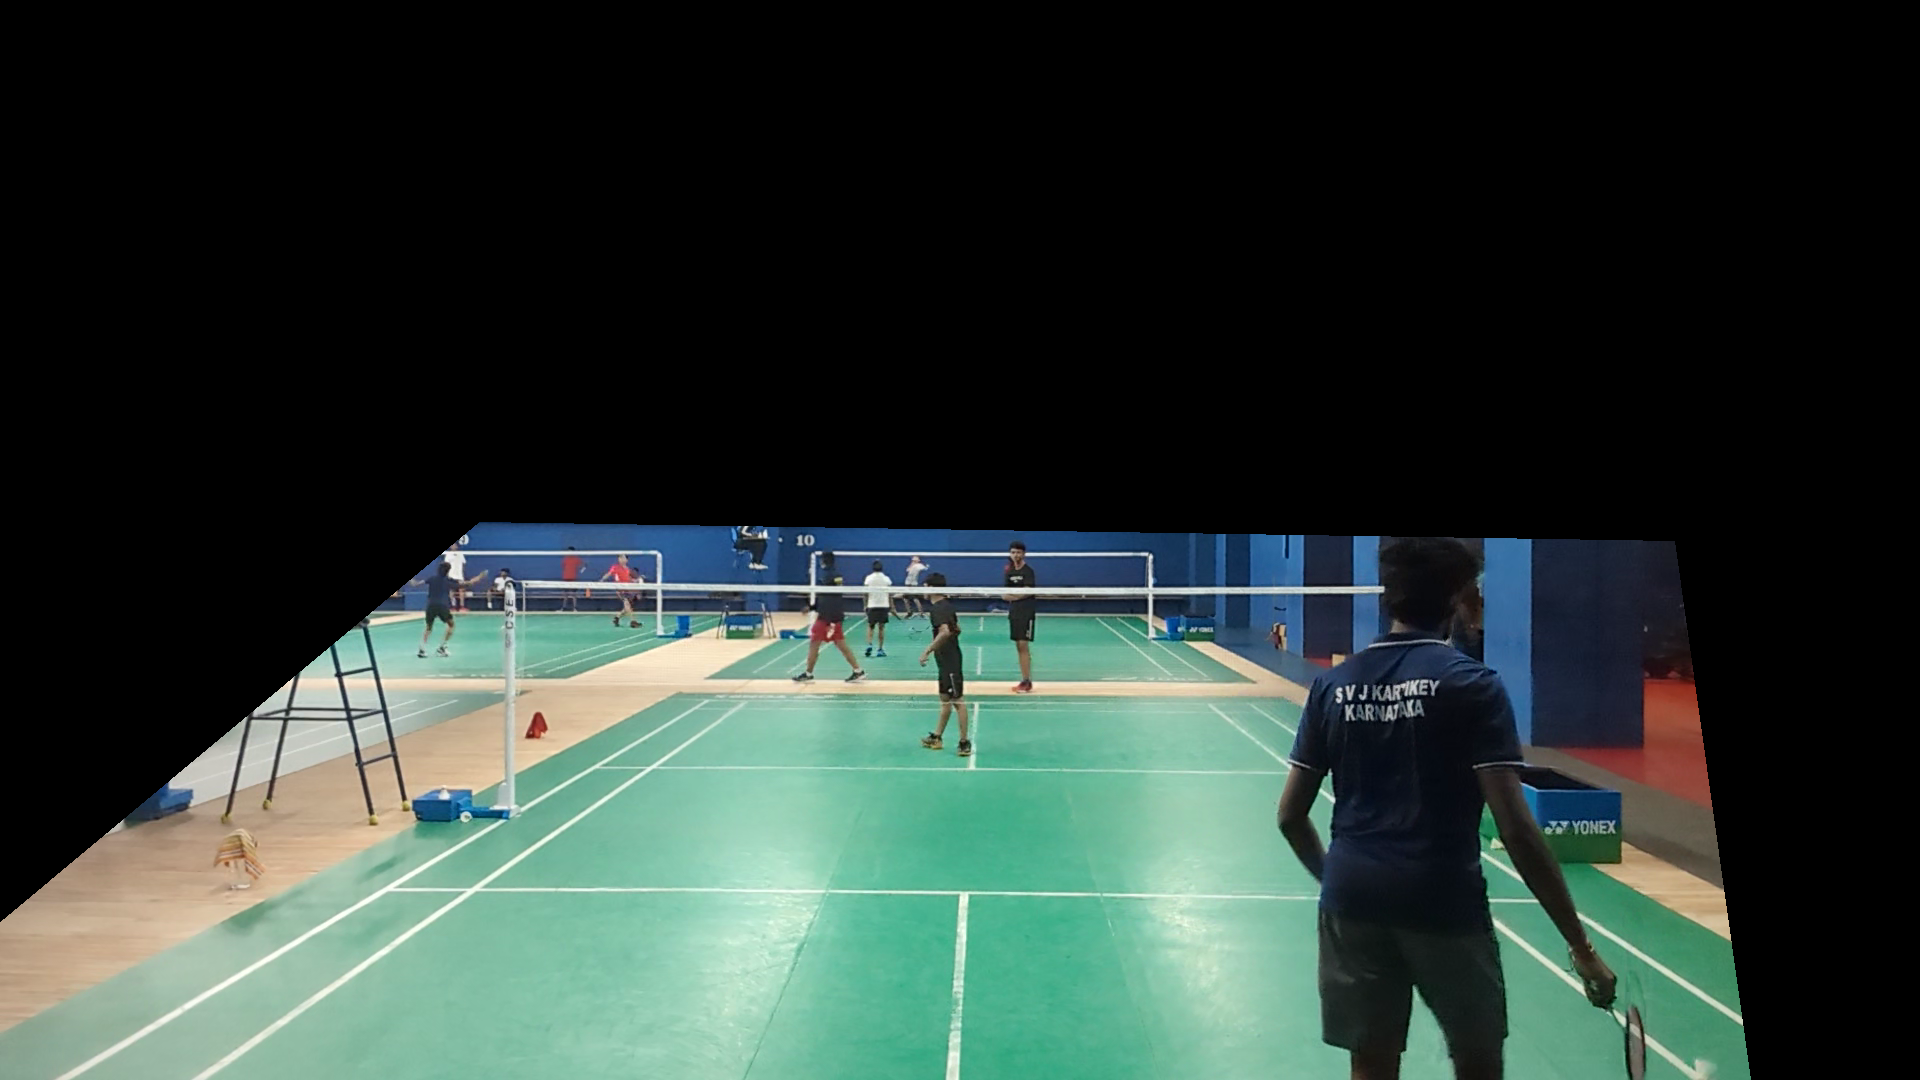

In [ ]:
# import cv2
# import numpy as np
# from google.colab.patches import cv2_imshow  # For displaying images in Colab

# def adjust_boundary(points, scale_factor=1.0):
#     center = np.mean(points, axis=0)
#     adjusted_points = (points - center) * scale_factor + center
#     return adjusted_points.astype(int)

# def detect_court(frame, scale_factor=1.0):
#     # Convert to HSV color space
#     hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

#     # Define HSV range for court color (adjust based on video)
#     lower_green = np.array([35, 50, 50])
#     upper_green = np.array([85, 255, 255])

#     # Threshold to isolate court color
#     mask = cv2.inRange(hsv, lower_green, upper_green)

#     # Morphological operations to clean the mask
#     kernel = np.ones((5, 5), np.uint8)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

#     # Find contours
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if not contours:
#         return None

#     # Select the largest contour
#     largest_contour = max(contours, key=cv2.contourArea)

#     # Approximate contour to a polygon
#     epsilon = 0.02 * cv2.arcLength(largest_contour, True)
#     approx = cv2.approxPolyDP(largest_contour, epsilon, True)

#     if len(approx) != 4:
#         return None

#     return adjust_boundary(approx.reshape(4, 2), scale_factor)

# if __name__ == "__main__":
#     input_video = "/content/drive/MyDrive/PXL_20250125_091952723.TS.mp4"  # Update the path as needed
#     scale_factor = 1.9  # Adjust the court boundary dynamically

#     cap = cv2.VideoCapture(input_video)
#     if not cap.isOpened():
#         print("Error opening video file")
#     else:
#         # Get the total number of frames in the video
#         total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#         # Choose one random frame index
#         random_frame = np.random.randint(100, total_frames)
#         cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)

#         ret, frame = cap.read()
#         if ret:
#             # Fix upside-down frames if needed
#             frame = cv2.flip(frame, -1)

#             # Process the frame with the court detection model
#             court_points = detect_court(frame, scale_factor)
#             if court_points is not None:
#                 # Create a mask based on the detected court boundary
#                 mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
#                 cv2.fillConvexPoly(mask, court_points, 255)
#                 output_frame = cv2.bitwise_and(frame, frame, mask=mask)
#             else:
#                 output_frame = frame  # If no court is detected, show the original frame

#             # Display the output frame in Colab
#             cv2_imshow(output_frame)
#         else:
#             print("Could not read frame")

#     cap.release()
